In [1]:
%load_ext autoreload
%autoreload 2
from transformers import PreTrainedModel, PretrainedConfig
from transformers import AutoModel, AutoConfig, AutoTokenizer
from omegaconf import OmegaConf
import hydra
from einops import repeat
import pyvene as pv
import torch
import wandb
from tasks.regression import *
import os
import gc
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Sandbox

In [2]:
experiments = {
    "explicit-transformer": "1ejrnua7",
    "explicit-mlp": "hb9li9ry",
    "explicit-aux-transformer": "hzr77fqz",
    "implicit": "huqr2bcp",
}

In [3]:
EXP = 'explicit-transformer'

In [4]:
api = wandb.Api()
run = api.run(f'leogagnon/Explicit-Implicit/runs/{experiments[EXP]}')
artifact = api.artifact(f'leogagnon/Explicit-Implicit/model-{experiments[EXP]}:latest')
path = artifact.download()

wandb:   1 of 1 files downloaded.  


In [5]:
pl_module = RegressionICL.load_from_checkpoint(
    checkpoint_path=os.path.join(path,'model.ckpt'),
    strict=False,
    model=hydra.utils.instantiate(run.config['model_config']),
).to('cuda')

/home/mila/l/leo.gagnon/explicit_implicit_icl/venv/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:177: Found keys that are not in the model state dict but in the checkpoint: ['w_predictor.weight', 'w_predictor.bias']


In [6]:
class MyConfig(PretrainedConfig):
    model_type = 'mymodel'
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

class MyModel(PreTrainedModel):
    config_class = MyConfig
    def __init__(self, config):
        super().__init__(config)
        self.config = config
        self.model = pl_module.model
    def forward(self, x_c, y_c, x_q):
        return self.model(x_c, y_c, x_q) 

In [8]:
hf_model = MyModel(MyConfig())
if EXP == "implicit":
    pv_config = pv.IntervenableConfig(
        representations=[
            pv.RepresentationConfig(
                component=f"model.encoder.layers[{i}].output",
                intervention=pv.LowRankRotatedSpaceIntervention(
                    embed_dim=256, low_rank_dimension=10
                )
            )
            for i in [3,5]
        ]
    )
else:
    pv_config = pv.IntervenableConfig(
        representations=pv.RepresentationConfig(
            component="model.context_model.output",
            intervention=pv.LowRankRotatedSpaceIntervention(
                embed_dim=256, low_rank_dimension=10
            ),
        )
    )
pv_model = pv.IntervenableModel(config=pv_config, model=hf_model)
pv_model.set_device("cuda")

In [9]:
datamodule = hydra.utils.instantiate(run.config['experiment_config']['experiment']['data'])

In [14]:
val_idx = {'iid': 0, 'far': 1, 'wide': 2}
VAL_STYLE = 'wide'

In [15]:
opt = torch.optim.Adam(pv_model.get_trainable_parameters())
pv_model.model.eval()

train_loss_traj = []
val_loss_traj = []
for epoch in range(10):
    train_loss = []
    for batch in datamodule.train_dataloader():
        base = {
            "x_c": batch[0][0].cuda(),
            "y_c": batch[0][1].cuda(),
            "x_q": batch[1][0].cuda(),
        }
        c_len = batch[0][0].shape[1]

        # Different context, different queries, different latent
        x_c_source, x_q_source = datamodule.train_data.sample_x(c_len)
        w_source = datamodule.train_data.sample_function_params()
        source = {
            "x_c": x_c_source.cuda(),
            "y_c": datamodule.train_data.function(x_c_source, w_source).cuda(),
            "x_q": x_q_source.cuda(),
        }
        unit_locations = (
            {"sources->base": c_len - 1}
            if EXP == "implicit"
            else None
        )
        y_q_intervened = pv_model(base, source, unit_locations=unit_locations)[1][0]
        y_q_counterfactual = datamodule.train_data.function(
            batch[1][0], w_source
        ).cuda()

        loss = torch.nn.functional.mse_loss(y_q_intervened, y_q_counterfactual)

        loss.backward()
        train_loss += [loss.detach().cpu().item()]
        opt.step()
        opt.zero_grad()

    train_loss_traj += [sum(train_loss) / len(train_loss)]
    print("Train loss :", train_loss_traj[-1])
    
    with torch.no_grad():
        for batch in datamodule.val_dataloader()[val_idx[VAL_STYLE]]:
            gc.collect()
            base = {
                "x_c": batch[0][0].cuda(),
                "y_c": batch[0][1].cuda(),
                "x_q": batch[1][0].cuda(),
            }
            c_len = batch[0][0].shape[1]
            bs = batch[0][0].shape[0]

            # Different context, different queries, different latent
            x_c_source, x_q_source = datamodule.val_data[VAL_STYLE].sample_x(
                batch[0][0].shape[1]
            )
            w_source = datamodule.val_data[VAL_STYLE].sample_function_params()
            source = {
                "x_c": x_c_source.cuda(),
                "y_c": datamodule.val_data[VAL_STYLE].function(x_c_source, w_source).cuda(),
                "x_q": x_q_source.cuda(),
            }

            unit_locations = (
                {"sources->base": c_len - 1}
                if EXP == "implicit"
                else None
            )
            y_q_intervened = pv_model(base, source, unit_locations=unit_locations)[1][0]
            y_q_counterfactual = (
                datamodule.val_data[VAL_STYLE].function(batch[1][0], w_source).cuda()
            )

            loss = torch.nn.functional.mse_loss(y_q_intervened, y_q_counterfactual)
            val_loss_traj += [loss.cpu().item()]
            print("Val loss :", loss)

Train loss : 3.198320116315569
Val loss : tensor(13.1080, device='cuda:0')
Train loss : 1.874198590006147
Val loss : tensor(6.2786, device='cuda:0')
Train loss : 0.5793971355472293
Val loss : tensor(2.3316, device='cuda:0')
Train loss : 0.22932793625763484
Val loss : tensor(1.2753, device='cuda:0')
Train loss : 0.15301584558827536
Val loss : tensor(0.9138, device='cuda:0')
Train loss : 0.10284969849245888
Val loss : tensor(0.7651, device='cuda:0')
Train loss : 0.05476683271782739
Val loss : tensor(0.5624, device='cuda:0')
Train loss : 0.03585385424750192
Val loss : tensor(0.5677, device='cuda:0')
Train loss : 0.03415108525327274
Val loss : tensor(0.5631, device='cuda:0')
Train loss : 0.02626355178654194
Val loss : tensor(0.5083, device='cuda:0')


In [24]:
implicit_mse = val_loss_traj[-1]

In [36]:
explicitMLP_mse = val_loss_traj[-1]

In [44]:
explicitTSF_mse = val_loss_traj[-1]

In [45]:
counterfactual_mse = [implicit_mse, explicitTSF_mse, explicitMLP_mse]

# Figures

In [6]:
experiments = {
    "explicit-transformer": "1ejrnua7",
    "explicit-mlp": "hb9li9ry",
    "explicit-aux-transformer": "hzr77fqz",
    "implicit": "huqr2bcp",
}
val_idx = {'iid': 0, 'far': 1, 'wide': 2}


def val_intervention_acc(val_style, exp):

    api = wandb.Api()
    run = api.run(f'leogagnon/Explicit-Implicit/runs/{experiments[exp]}')
    artifact = api.artifact(f'leogagnon/Explicit-Implicit/model-{experiments[exp]}:latest')
    path = artifact.download()

    pl_module = RegressionICL.load_from_checkpoint(
        checkpoint_path=os.path.join(path,'model.ckpt'),
        strict=False,
        model=hydra.utils.instantiate(run.config['model_config']),
    ).to('cuda')

    class MyConfig(PretrainedConfig):
        model_type = 'mymodel'
        def __init__(self, **kwargs):
            super().__init__(**kwargs)

    class MyModel(PreTrainedModel):
        config_class = MyConfig
        def __init__(self, config):
            super().__init__(config)
            self.config = config
            self.model = pl_module.model
        def forward(self, x_c, y_c, x_q):
            return self.model(x_c, y_c, x_q) 

    hf_model = MyModel(MyConfig())
    if exp == "implicit":
        pv_config = pv.IntervenableConfig(
            representations=[
                pv.RepresentationConfig(
                    component=f"model.encoder.layers[{i}].output",
                    intervention=pv.LowRankRotatedSpaceIntervention(
                        embed_dim=256, low_rank_dimension=10
                    )
                )
                for i in [3,5]
            ]
        )
    else:
        pv_config = pv.IntervenableConfig(
            representations=pv.RepresentationConfig(
                component="model.context_model.output",
                intervention=pv.LowRankRotatedSpaceIntervention(
                    embed_dim=256, low_rank_dimension=10
                ),
            )
        )
    pv_model = pv.IntervenableModel(config=pv_config, model=hf_model)
    pv_model.set_device("cuda")

    datamodule = hydra.utils.instantiate(run.config['experiment_config']['experiment']['data'])

    opt = torch.optim.Adam(pv_model.get_trainable_parameters())
    pv_model.model.eval()

    train_loss_traj = []
    val_loss_traj = []
    for epoch in range(10):
        train_loss = []
        for batch in datamodule.train_dataloader():
            base = {
                "x_c": batch[0][0].cuda(),
                "y_c": batch[0][1].cuda(),
                "x_q": batch[1][0].cuda(),
            }
            c_len = batch[0][0].shape[1]

            # Different context, different queries, different latent
            x_c_source, x_q_source = datamodule.train_data.sample_x(c_len)
            w_source = datamodule.train_data.sample_function_params()
            source = {
                "x_c": x_c_source.cuda(),
                "y_c": datamodule.train_data.function(x_c_source, w_source).cuda(),
                "x_q": x_q_source.cuda(),
            }
            unit_locations = (
                {"sources->base": c_len - 1}
                if exp == "implicit"
                else None
            )
            y_q_intervened = pv_model(base, source, unit_locations=unit_locations)[1][0]
            y_q_counterfactual = datamodule.train_data.function(
                batch[1][0], w_source
            ).cuda()

            loss = torch.nn.functional.mse_loss(y_q_intervened, y_q_counterfactual)

            loss.backward()
            train_loss += [loss.detach().cpu().item()]
            opt.step()
            opt.zero_grad()

        train_loss_traj += [sum(train_loss) / len(train_loss)]
        print("Train loss :", train_loss_traj[-1])
        
        with torch.no_grad():
            for batch in datamodule.val_dataloader()[val_idx[val_style]]:
                gc.collect()
                base = {
                    "x_c": batch[0][0].cuda(),
                    "y_c": batch[0][1].cuda(),
                    "x_q": batch[1][0].cuda(),
                }
                c_len = batch[0][0].shape[1]
                bs = batch[0][0].shape[0]

                # Different context, different queries, different latent
                x_c_source, x_q_source = datamodule.val_data[val_style].sample_x(
                    batch[0][0].shape[1]
                )
                w_source = datamodule.val_data[val_style].sample_function_params()
                source = {
                    "x_c": x_c_source.cuda(),
                    "y_c": datamodule.val_data[val_style].function(x_c_source, w_source).cuda(),
                    "x_q": x_q_source.cuda(),
                }

                unit_locations = (
                    {"sources->base": c_len - 1}
                    if exp == "implicit"
                    else None
                )
                y_q_intervened = pv_model(base, source, unit_locations=unit_locations)[1][0]
                y_q_counterfactual = (
                    datamodule.val_data[val_style].function(batch[1][0], w_source).cuda()
                )

                loss = torch.nn.functional.mse_loss(y_q_intervened, y_q_counterfactual)
                val_loss_traj += [loss.cpu().item()]
                print("Val loss :", loss)
    return val_loss_traj[-1]

In [8]:
accs = torch.zeros(3,3)

In [ ]:
for i, v in enumerate(["iid", "far", "wide"]):
    for j, e in enumerate(["implicit", "explicit-transformer", "explicit-mlp"]):
        accs[i, j] = val_intervention_acc(v, e)

In [31]:
data = pd.melt(
    pd.DataFrame(accs).reset_index(),
    id_vars="index",
    var_name="Model",
    value_name="value",
)
data.rename(columns={"index": "OOD style"}, inplace=True)
data.rename(columns={"value": "Counterfactual MSE"}, inplace=True)

data['Model'] = data['Model'].map({0: 'Implicit', 1: 'Explicit Transformer', 2: 'Explicit MLP'})
data['OOD style'] = data['OOD style'].map({0: 'IID', 1: 'Far', 2: 'Wide'})

In [65]:
# Style for making nice-looking paper plots with page-scale figure size units
sns.set_theme(
    style="ticks",
    context="paper",
    rc={
        "font.size": 5,
        "axes.titlesize": 6,
        "axes.labelsize": 6,
        "axes.labelpad": 2,
        "xtick.labelsize": 4.5,
        "ytick.labelsize": 4.5,
        "legend.title_fontsize": 4.5,
        "legend.fontsize": 4.5,
        "legend.markerscale": 0.5,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.linewidth": 0.4,
        "xtick.major.width": 0.4,
        "ytick.major.width": 0.4,
        "xtick.major.size": 2.5,
        "ytick.major.size": 2.5,
        "xtick.minor.size": 1.5,
        "ytick.minor.size": 1.5,
        "xtick.minor.width": 0.2,
        "ytick.minor.width": 0.2,
        "figure.constrained_layout.use": True,
        "figure.dpi": 200,
    },
)

/home/mila/l/leo.gagnon/explicit_implicit_icl/venv/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/mila/l/leo.gagnon/explicit_implicit_icl/venv/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/mila/l/leo.gagnon/explicit_implicit_icl/venv/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

(0.0, 2.0)

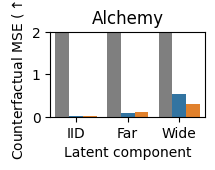

In [37]:
default_model_colours = {
    "implicit": sns.color_palette()[7],
    "explicit-transformer": sns.color_palette()[0],
    "explicit-mlp": sns.color_palette()[1],
    "explicit-aux-transformer": sns.color_palette()[4],
    "explicit-known": sns.color_palette()[2],
}

fig, ax = plt.subplots(figsize=(2, 1.1))

sns.barplot(
    data=data,
    ax=ax,
    x="OOD style",
    y="Counterfactual MSE",
    hue="Model",
    hue_order=["Implicit", "Explicit Transformer", "Explicit MLP"],
    palette=[
        default_model_colours[m]
        for m in ["implicit", "explicit-transformer", "explicit-mlp"]
    ],
    err_kws={"linewidth": 1.25},
)
ax.legend().remove()
ax.set(
    title="Alchemy",
    xlabel="Latent component",
    ylabel=r"Counterfactual MSE ($\uparrow$)",
)
ax.set_ylim([0,2])